# Notebook du CNN construit à partir de zéro | Stanford dogs dataset

---
## Contexte

Vous êtes bénévole pour l'association de protection des animaux de votre quartier. C'est d'ailleurs ainsi que vous avez trouvé votre compagnon idéal, Snooky. Vous vous demandez donc ce que vous pouvez faire en retour pour aider l'association.

Vous apprenez, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc obtenir un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.

## Les données
Les bénévoles de l'association n'ont pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs. Pas de problème, vous entraînerez votre algorithme en utilisant le Stanford Dogs Dataset.

## Mission
L'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

Vous avez peu d’expérience sur le sujet, vous décidez donc de contacter un ami expert en classification d’images.

Il vous conseille dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).

Ensuite, il vous incite à mettre en œuvre deux approches s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels), que vous comparerez en termes de temps de traitement et de résultat :

* Une première en réalisant votre propre réseau CNN, en vous inspirant de réseaux CNN existants. Prenez soin d'optimiser certains hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)
* Une deuxième en utilisant le transfer learning, c’est-à-dire en utilisant un réseau déjà entraîné, et en le modifiant pour répondre à votre problème.

Concernant le transfer learning, votre ami vous précise que :

* Une première chose obligatoire est de réentraîner les dernières couches pour prédire les classes qui vous intéressent seulement.
* Il est également possible d’adapter la structure (supprimer certaines couches, par exemple) ou de réentraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

## Ressources de calcul
Votre ami vous alerte sur le fait que l'entraînement (même partiel) d'un réseau de neurones convolutionnels est très gourmand en ressources. Si le processeur de l’ordinateur un peu ancien de l’association ne suffit pas, il vous propose plusieurs solutions :

* Limitez le jeu de données, en ne sélectionnant que quelques classes (races de chiens), ce qui permettra déjà de tester la démarche et la conception des modèles, avant une éventuelle généralisation.
* Utilisez la carte graphique de l’ordinateur en tant que GPU (l'installation est un peu fastidieuse, et l'ordinateur est inutilisable le temps du calcul).

Ce notebook montre les différentes expériences et les différentes approches que j'ai pu testées. Il se base sur 12 races seulement (10 % de charge)

In [1]:
!pip install keras

In [2]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
import kerastuner as kt
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import six

import matplotlib.pyplot as plt
plt.style.use("default")
import seaborn as sns
import keras_tuner
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [3]:
# Création des fonctions
def get_dataframe(path, n_breeds=12):
    dogs_lst = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            dogs_lst.append(os.path.join(dirname, filename))

    # Je stocke dans un dataframe
    dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

    # J'extrais la race
    dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)
    
    # Délimitation du nombre de race
    top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
    dogs = pd.DataFrame()
    for b in top_breeds:
        dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

    return dogs


def split_and_generate_dataframe(df, px):
    seed = 42

    # Séparation des données d'entrainements et de tests
    train, test = train_test_split(df, test_size=0.2, random_state=seed)
    # Séparation des données d'entrainements et de validation
    train, val = train_test_split(train, test_size=0.2, random_state=seed)

    ### Paramétrage
    x = 'uri'
    y = 'breeds'

    train_batch_size = get_batch_size(len(train))
    val_batch_size = get_batch_size(len(val))
    test_batch_size = get_batch_size(len(test))

    train_datagen = ImageDataGenerator(rescale=1./255)
    train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Sans augmentation des données
    train_gen = train_datagen.flow_from_dataframe(
                      train,
                      x_col='uri',
                      y_col='breeds',
                      target_size=(px, px),
                      batch_size=train_batch_size,
                      seed=seed
                      )


    # Avec augmentation des données
    train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                              train,
                              x_col='uri',
                              y_col='breeds',
                              target_size=(px, px),
                              batch_size=train_batch_size,
                              seed=seed
                              )

    val_gen = val_test_datagen.flow_from_dataframe(
                      val,
                      x_col = x,
                      y_col = y,
                      target_size=(px, px),
                      batch_size=val_batch_size,
                      seed=seed
                      )

    test_gen = val_test_datagen.flow_from_dataframe(
                      test,
                      x_col = x,
                      y_col = y,
                      target_size=(px, px),
                      batch_size=test_batch_size,
                      seed=seed,
                      shuffle=False
                      )

    return [train_gen, train_gen_data_aug, val_gen, test_gen]

def get_batch_size(gen):
    lst = []
    dict = {}
    
    # Test des nombres entiers et intégration dans un dictionnaire
    for i in range(1,40):
        dict[i] = gen % i
    
    # Récupération du plus grand nombre entiers
    for key, value in dict.items():
        if value == 0:
            lst.append(key)

    return max(lst)


def get_model(act_function):
    model = Sequential()
    ### Couches de convolutions
    # Couche 1
    model.add(Conv2D(32, (3, 3), activation=act_function, input_shape=(256, 256, 3)))
    model.add(MaxPooling2D((2, 2)))

    # Couche 2
    model.add(Conv2D(64, (3, 3), activation=act_function))
    model.add(MaxPooling2D((2, 2)))

    # Couche 3
    model.add(Conv2D(128, (3, 3), activation=act_function))
    model.add(MaxPooling2D((2, 2)))
    
    # Couche 4
    model.add(Conv2D(128, (3, 3), activation=act_function))
    model.add(MaxPooling2D((2, 2)))
    
    # Couche 5
    model.add(Conv2D(128, (3, 3), activation=act_function))
    model.add(MaxPooling2D((2, 2)))


    return model


def plot_activation_functions(history, subtitle):
    # Extraction des historique
    val_loss = {k:v.history['val_loss'] for k,v in activation_results.items()}
    val_acc = {k:v.history['val_accuracy'] for k,v in activation_results.items()}
    # Conversion en df
    val_loss_curves = pd.DataFrame(val_loss)
    val_acc_curves = pd.DataFrame(val_acc)
    # Graphique
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    
    ax[0].plot(val_loss_curves.LeakyReLU, label='LeakyReLU')
    ax[0].plot(val_loss_curves.relu, label='relu')
    ax[0].plot(val_loss_curves.elu, label='elu')
    ax[0].plot(val_loss_curves.sigmoid, label='sigmoid')
    ax[0].plot(val_loss_curves.tanh, label='tanh')
    ax[0].set_title('val_loss | ' + subtitle + ' | Activation Function')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Val_loss')
    ax[0].legend()

    
    ax[1].plot(val_acc_curves.LeakyReLU, label='LeakyReLU')
    ax[1].plot(val_acc_curves.relu, label='relu')
    ax[1].plot(val_acc_curves.elu, label='elu')
    ax[1].plot(val_acc_curves.sigmoid, label='sigmoid')
    ax[1].plot(val_acc_curves.tanh, label='tanh')
    ax[1].set_title('val_accuracy | ' + subtitle + ' | Activation Function')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('val_accuracy')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + subtitle + '_activation_function.png',
                    transparent=True)
    return None


def plot_optimizer(history, subtitle):
    # Extraction des historique
    val_loss = {k:v.history['val_loss'] for k,v in opt_results.items()}
    val_acc = {k:v.history['val_accuracy'] for k,v in opt_results.items()}
    # Conversion en df
    val_loss_curves = pd.DataFrame(val_loss)
    val_acc_curves = pd.DataFrame(val_acc)
    # Graphique
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    
    ax[0].plot(val_loss_curves.adamax, label='adamax')
    ax[0].plot(val_loss_curves.adam, label='adam')
    ax[0].plot(val_loss_curves.RMSProp, label='RMSProp')
    ax[0].plot(val_loss_curves.SGD, label='SGD')
    

    
    ax[0].set_title('val_loss | ' + subtitle + ' | Optimizers')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Val_loss')
    ax[0].legend()

    ax[1].plot(val_acc_curves.adamax, label='adamax')
    ax[1].plot(val_acc_curves.adam, label='adam')
    ax[1].plot(val_acc_curves.RMSProp, label='RMSProp')
    ax[1].plot(val_acc_curves.SGD, label='SGD')
   
    ax[1].set_title('val_accuracy | ' + subtitle + ' | Optimizers')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('val_accuracy')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + subtitle + '_optimizers.png',
                    transparent=True)
    return None


def plot_effect(history_std, history_modified, title, subtitle):
    # Conversion en dataframe
    df_model_std = pd.DataFrame(history_std.history['val_accuracy'], columns=["model_std"])
    df_model_modified = pd.DataFrame(history_modified.history['val_accuracy'], columns=[title])

    # Tracage
    pd.merge(df_model_std, df_model_modified, right_index=True, left_index=True).plot()
    plt.title(title + "_" + subtitle)
    plt.xlabel("epoch")
    plt.ylabel("val_accuracy")
    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + title + '.png',
                transparent=True)
    plt.show()
    return None


def plot_result_fitting(history, model, title, n_breeds):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Accuracy | ' + model + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Loss function | ' + model + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + model + '_' + title + '_' + str(n_breeds) + '_breeds_results.png',
                transparent=True)
    plt.show()
    return None


def plot_confusion_matrix(model, title, n_breeds):
    pred = model.predict_classes(test_gen)
    cf_matrix = confusion_matrix(test_gen.classes, pred)
    sns.heatmap(cf_matrix, cmap='Purples')
    plt.title('Matrice de confusion | ' + title + ' | ' + str(n_breeds) + ' breeds')
    plt.axis('off')
    plt.savefig('./cnn_transfer_learning_' + title + '_' + str(n_breeds) + '_breeds_confusion_matrix.png',
                transparent=True)
    plt.show()
    return

def export_png_table(data, col_width=2.2, row_height=0.625, font_size=10,
                     header_color='#7451eb', row_colors=['#f1f1f2', 'w'],
                     edge_color='w', bbox=[0, 0, 1, 1], header_columns=1,
                     ax=None, filename='table.png', **kwargs):
    ax = None
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])
                ) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox,
                         colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    fig.savefig(filename, transparent=True)

    return None

---
# 1. Limitation des données | Charge 10 % (12 races)

L'expérimentation se fait en 3 étapes :
* Mesure des effets des fonctions d'activations,
* Formation d'un modèle naif servant de baseline,
* Mesure de l'effet de BatchNormalization(),
* Mesure de l'effet de DropOut(),

Les résultats sur les données des tests sont comparés. Les sorties d'entraînements accuracy et loss sont analysés afin de détecter un éventuel surapprentissage.

Une phase d'expérimentation se fera sur 40 epochs. En fin de notebook, la fin sera réglé par un EarlyStopping.

In [4]:
# Paramètrage des données d'entrées
n_breeds = 12
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la phase d'expérimentation.")

# Création des générateurs
train_gen, train_gen_data_aug, val_gen, test_gen = split_and_generate_dataframe(dogs, 256)

subtitle = "CNN_from_scratch"

Nous avons 12 races sélectionnées pour la phase d'expérimentation.
Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.


---
# 2. Mesures des effets des fonctions d'activations

<img src="https://mlfromscratch.com/content/images/2019/12/activation-functions.gif"> 

*Sigmoid* La fonction sigmoide convertit les valeurs qu'elle reçoit dans l'intervalle réel [0, 1].

*tanh* - Tangente -
La tangente est très similaire à la sigmoïde, mais présente deux différences significatives : elle convertit les données dans l'intervalle [-1, 1] et possède un centrage zéro, ce qui élimine le deuxième problème de la sigmoïde. Les valeurs de gradient dans la rétro-propagation peuvent toujours être mises à zéro, néanmoins l'utilisation d'une tangente est généralement préférable.

*ReLU*
Le ReLU ou Rectified Linear Unit est devenu très populaire ces dernières années. Il calcule la fonction f(x) = max(0,x), c'est-à-dire qu'il fournit simplement les valeurs "zéro" et "non zéro". Cela résout le problème de la mise à zéro du gradient pour les nombres positifs. En outre, ReLU est très facile à calculer : environ six fois plus rapide que la sigmoïde et la tangente. Cependant, il manque à nouveau le centrage zéro.

Un autre inconvénient évident est que le gradient "meurt" toujours lorsque l'entrée est négative. Cela peut conduire à ce que la moitié des neurones soient inactifs et incapables de se mettre à jour. 
Vous pouvez essayer de résoudre le problème en fixant un taux d'apprentissage plus faible et en sélectionnant des pondérations différentes. Ou utilisez les modifications ReLU.

*Leaky ReLU*
La différence dans cette fonction est qu'elle présente une légère pente dans le demi-plan gauche - ce qui signifie qu'avec des données d'entrée négatives, le gradient ne sera pas nul. 

*ELU*
Cette fonction est similaire à la ReLU fuyante et présente tous ses avantages, mais elle inclut un exposant, ce qui la rend plus coûteuse à calculer. Elle doit être utilisée dans les cas où la robustesse aux données de bruit est importante pour vous.

*Maxout*
Maxout choisit la somme maximale des deux ensembles de poids multipliés par les données originales, en tenant compte du biais. De cette façon, il généralise ReLU et ReLU fuyant sans remettre à zéro le gradient. Mais, comme vous pouvez le deviner à l'aspect de la fonction, maxout nécessite de doubler les paramètres et les neurones.
Nous ne testerons pas Maxout pour des raisons de coût élevé.



In [ ]:
def plot_confusion_matrix(model, title, n_breeds):
    pred = model.predict_classes(test_gen)
    cf_matrix = confusion_matrix(test_gen.classes, pred)
    sns.heatmap(cf_matrix, cmap='Purples')
    plt.title('Matrice de confusion | ' + title + ' | ' + str(n_breeds) + ' breeds')
    plt.axis('off')
    plt.savefig('./cnn_transfer_learning_' + title + '_' + str(n_breeds) + '_breeds_confusion_matrix.png',
                transparent=True)
    plt.show()
    return


Test de la fonction d'activation LeakyReLU en cours ...


2022-07-28 14:40:02.813046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 14:40:02.960501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 14:40:02.961654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 14:40:02.963644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Test de la fonction d'activation relu en cours ...
Test de la fonction d'activation elu en cours ...
Test de la fonction d'activation sigmoid en cours ...
Test de la fonction d'activation tanh en cours ...


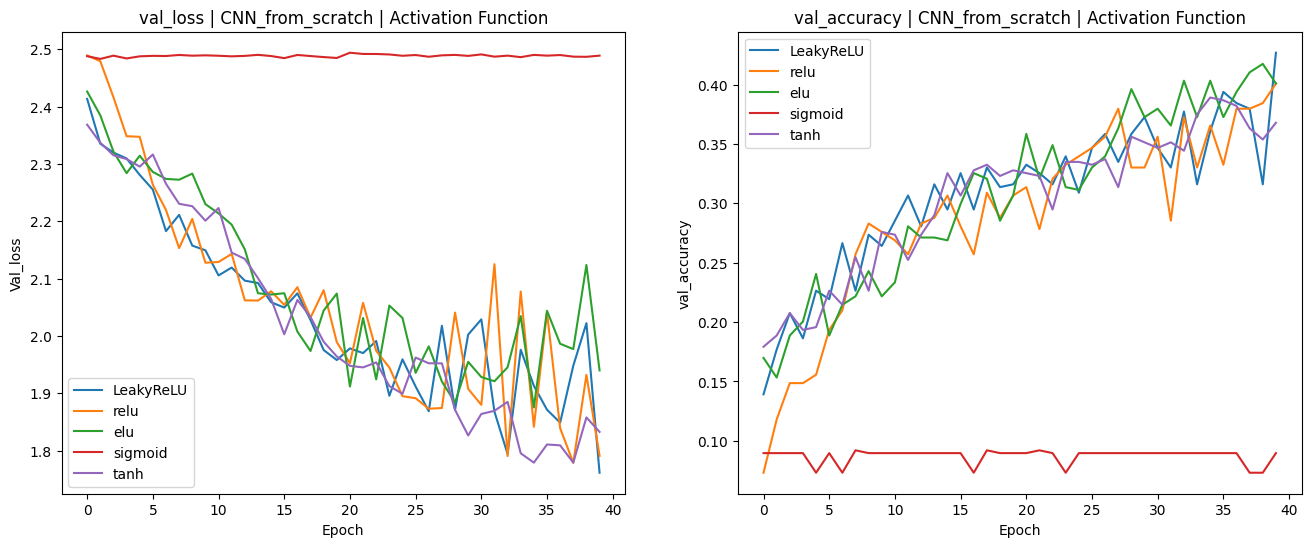

In [5]:
activations = ['LeakyReLU','relu','elu', 'sigmoid', 'tanh']
activation_results = {}

for funct in activations:
    print(f"Test de la fonction d'activation {funct} en cours ...")
    model = get_model(act_function=funct)
    
    ### Couches de Classification
    # Applatissement (transform to vector 1D)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    
    model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=40, verbose=0)
    activation_results[funct] = history

plot_activation_functions(history, subtitle)


La fonction d'activation LeakyReLU et relu présente les meilleurs résultats, elle sera conservé pour la suite de l'étude.

---
# 3. Mesures des effets des optimiseurs

Test de l'optimiseur adamax en cours ...
Test de l'optimiseur adam en cours ...
Test de l'optimiseur RMSProp en cours ...
Test de l'optimiseur SGD en cours ...


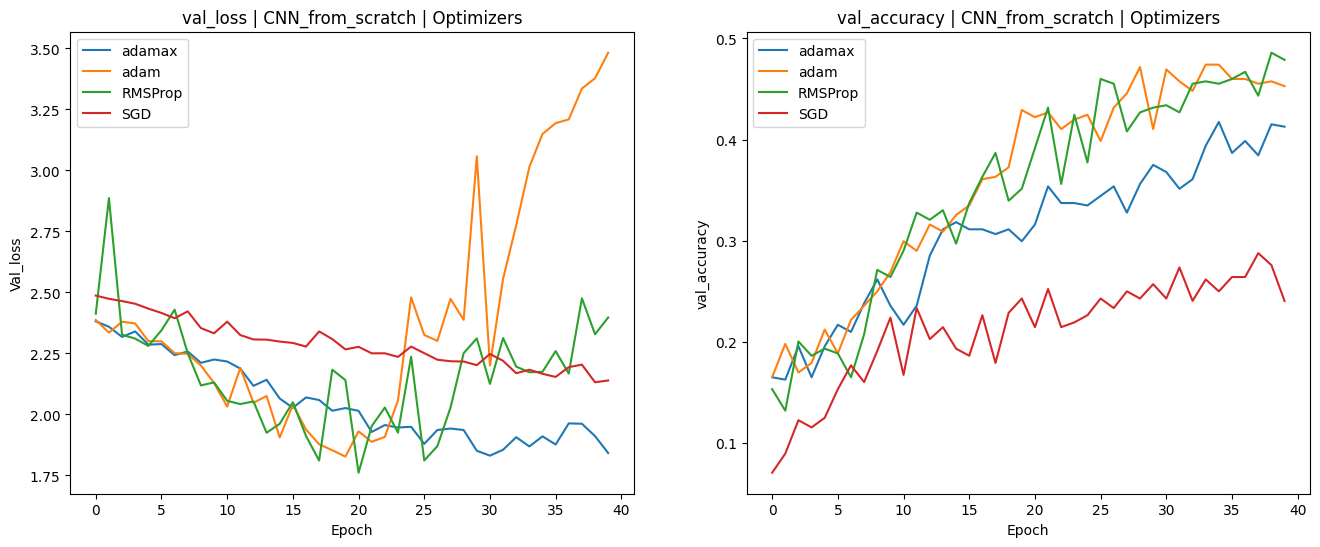

In [6]:
optimizers = ['adamax','adam', 'RMSProp', 'SGD']
opt_results = {}

for opt in optimizers:
    print(f"Test de l'optimiseur {opt} en cours ...")
    model = get_model(act_function='elu')
    
    ### Couches de Classification
    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    
    model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=40, verbose=0)
    opt_results[opt] = history

plot_optimizer(history, subtitle)

---
# 4. Mesures de quelques tests
## 4.1  Modèle standard lancé "naïvement"

In [7]:
epochs = 40
verbose = 0
act = 'elu'
opt = 'adamax'

test_accuracy = {}

53/53 [==============================] - 5s 102ms/step - loss: 1.7939 - accuracy: 0.4302


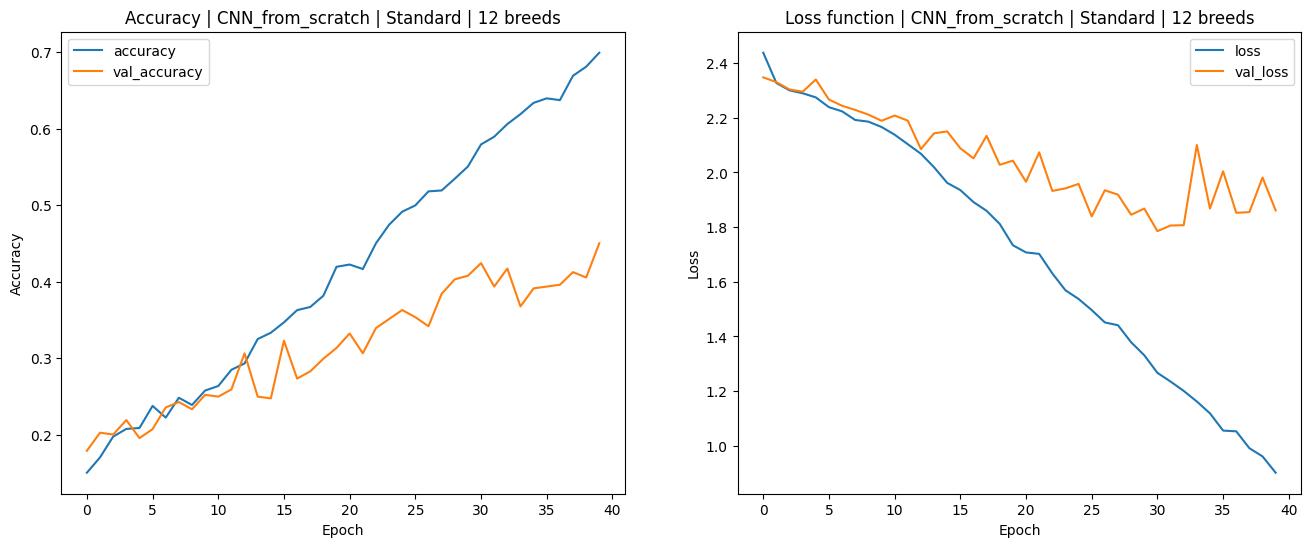

In [8]:
model_std = get_model(act_function=act)
### Couches de Classification
# Applatissement (transform to vector 1D)
model_std.add(GlobalAveragePooling2D())
model_std.add(Dense(len(train_gen.class_indices), activation='softmax'))

model_std.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

history_std = model_std.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

title = "Standard"
test_accuracy[title] = model_std.evaluate(test_gen)[1]
plot_result_fitting(history_std, subtitle, title, n_breeds)

## 4.2 Mesure de l'effet de Flatten() ou GlobalAveragePooling2D()

53/53 [==============================] - 3s 49ms/step - loss: 6.7925 - accuracy: 0.3057


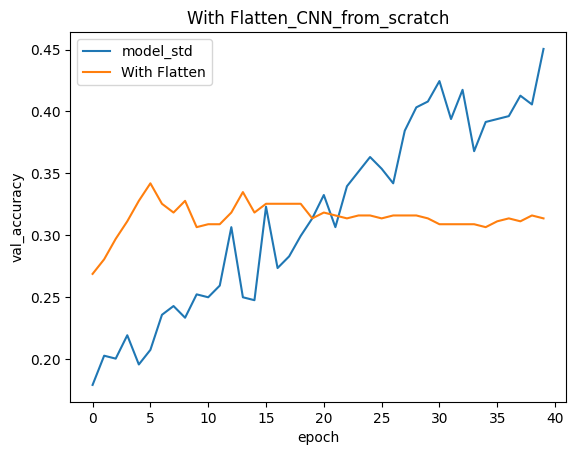

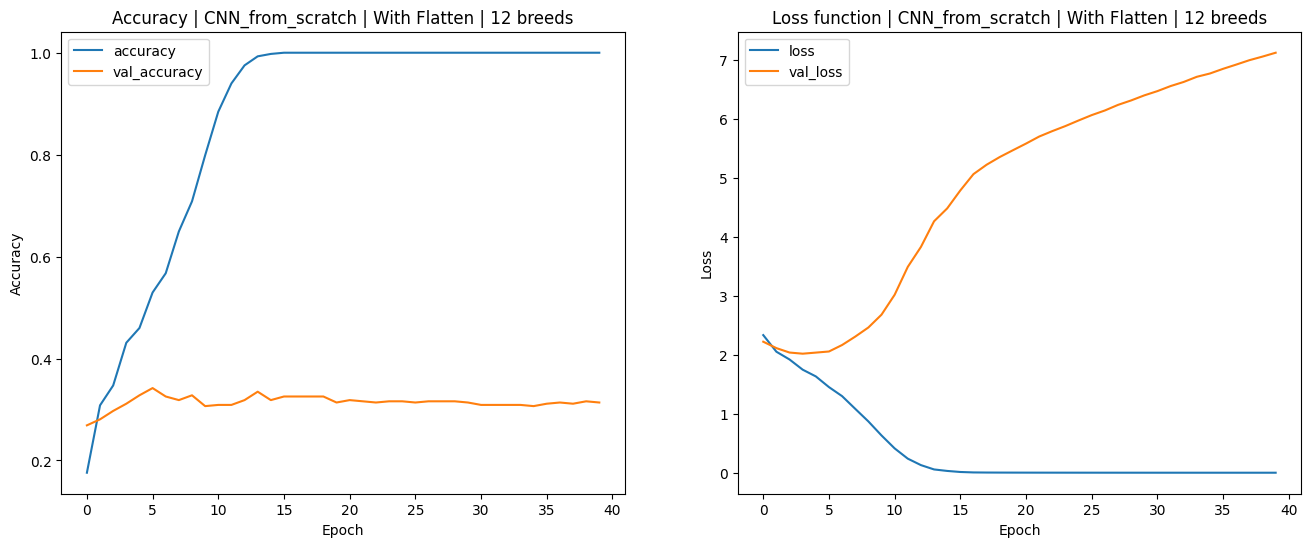

In [9]:
model_flatten = get_model(act_function=act)
### Couches de Classification
# Applatissement (transform to vector 1D)
model_flatten.add(Flatten())
model_flatten.add(Dense(len(train_gen.class_indices), activation='softmax'))

model_flatten.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

history_flatten = model_flatten.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)


title = "With Flatten"
test_accuracy[title] = model_flatten.evaluate(test_gen)[1]
plot_effect(history_std, history_flatten, title, subtitle)
plot_result_fitting(history_flatten, subtitle, title, n_breeds)

## 4.3 Mesure de l'effet d'une couche dense supplémentaire

53/53 [==============================] - 3s 56ms/step - loss: 1.8204 - accuracy: 0.4547


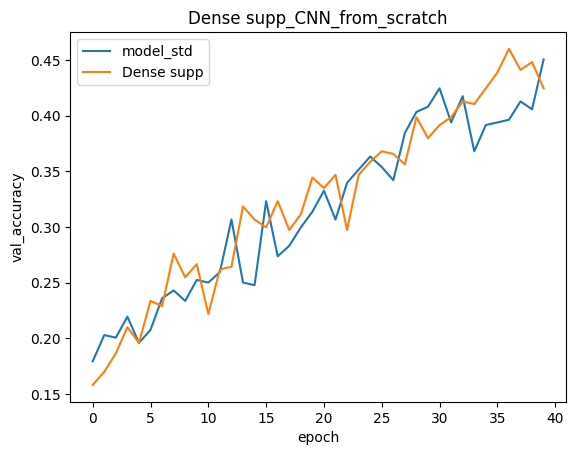

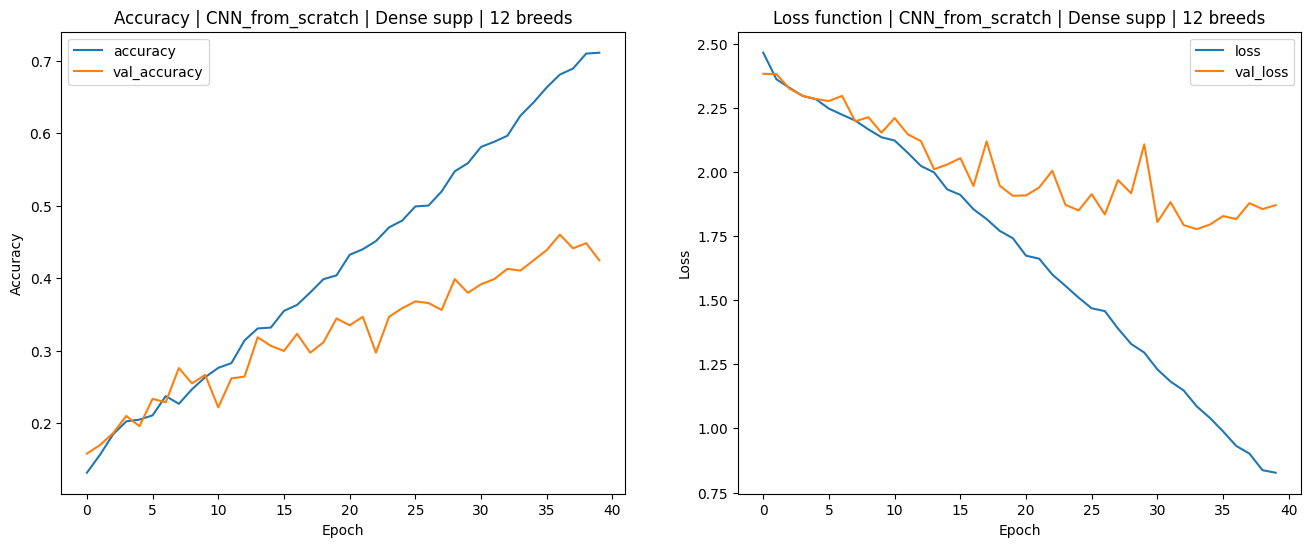

In [10]:
model_dense = get_model(act_function=act)
### Couches de Classification
# Applatissement (transform to vector 1D)
model_dense.add(GlobalAveragePooling2D())
model_dense.add(Dense(256, activation=act))
model_dense.add(Dense(len(train_gen.class_indices), activation='softmax'))

model_dense.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

history_dense = model_dense.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

title = "Dense supp"
test_accuracy[title] = model_dense.evaluate(test_gen)[1]
plot_effect(history_std, history_dense, title, subtitle)
plot_result_fitting(history_dense, subtitle, title, n_breeds)

## 4.4  Mesure de l'effet de BatchNormalization() - Amélioration de la précision

53/53 [==============================] - 3s 59ms/step - loss: 1.5939 - accuracy: 0.4642


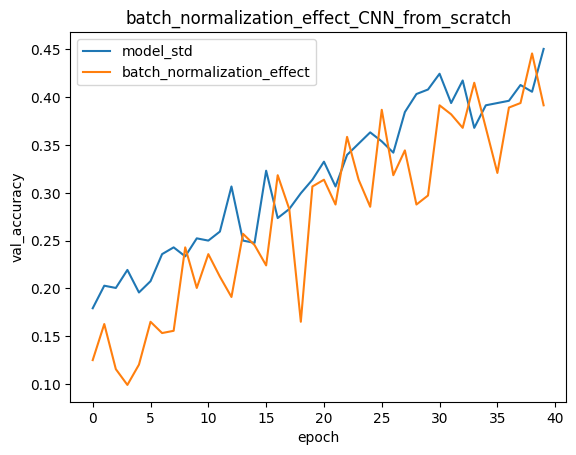

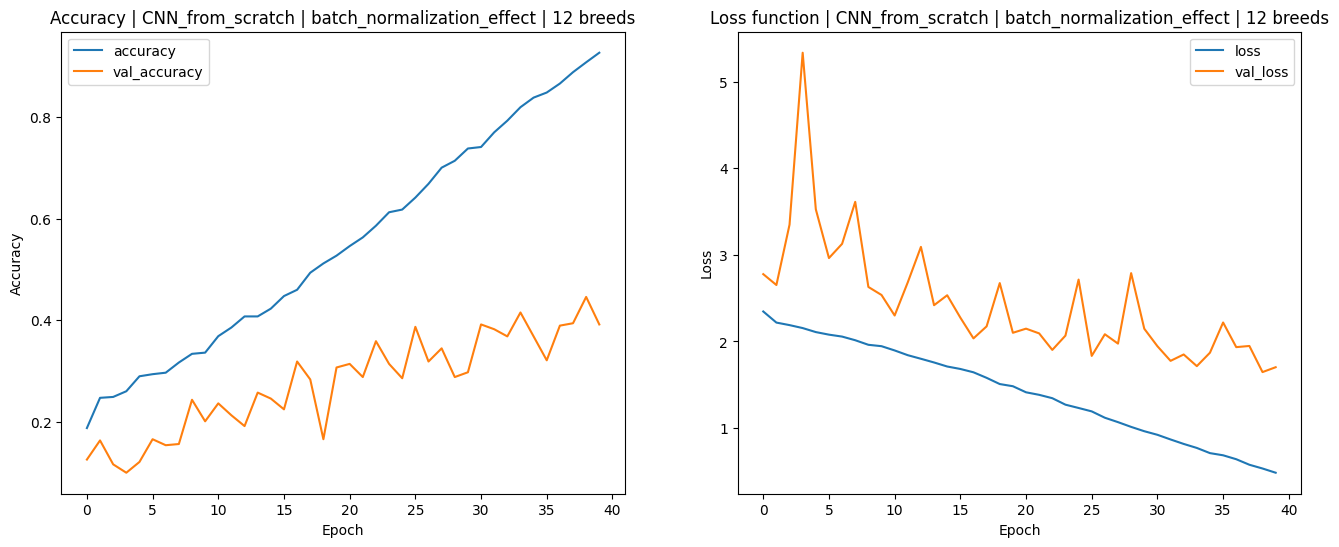

In [11]:
model_batch = get_model(act_function=act)
model_batch.add(BatchNormalization())

### Couches de Classification
# Applatissement (transform to vector 1D)
model_batch.add(GlobalAveragePooling2D())
model_batch.add(Dense(len(train_gen.class_indices), activation='softmax'))

# Complitation
model_batch.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Mesure des effets de la couche
history_batch = model_batch.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

title = "batch_normalization_effect"
test_accuracy[title] = model_batch.evaluate(test_gen)[1]
plot_effect(history_std, history_batch, title, subtitle)
plot_result_fitting(history_batch, subtitle, title, n_breeds)

## 4.5  Mesure de l'effet de DropOut() - Régulation du surapprentissage

Test de la valeur 0.2 en cours ...
53/53 [==============================] - 3s 51ms/step - loss: 1.8539 - accuracy: 0.4453


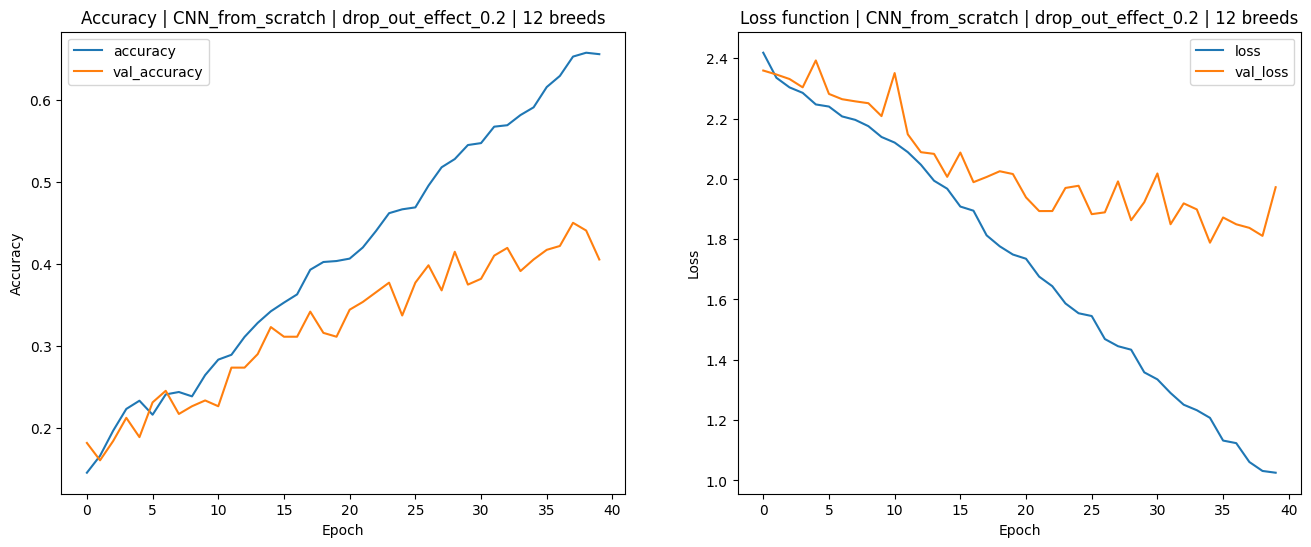

Test de la valeur 0.5 en cours ...
53/53 [==============================] - 3s 47ms/step - loss: 1.7138 - accuracy: 0.4094


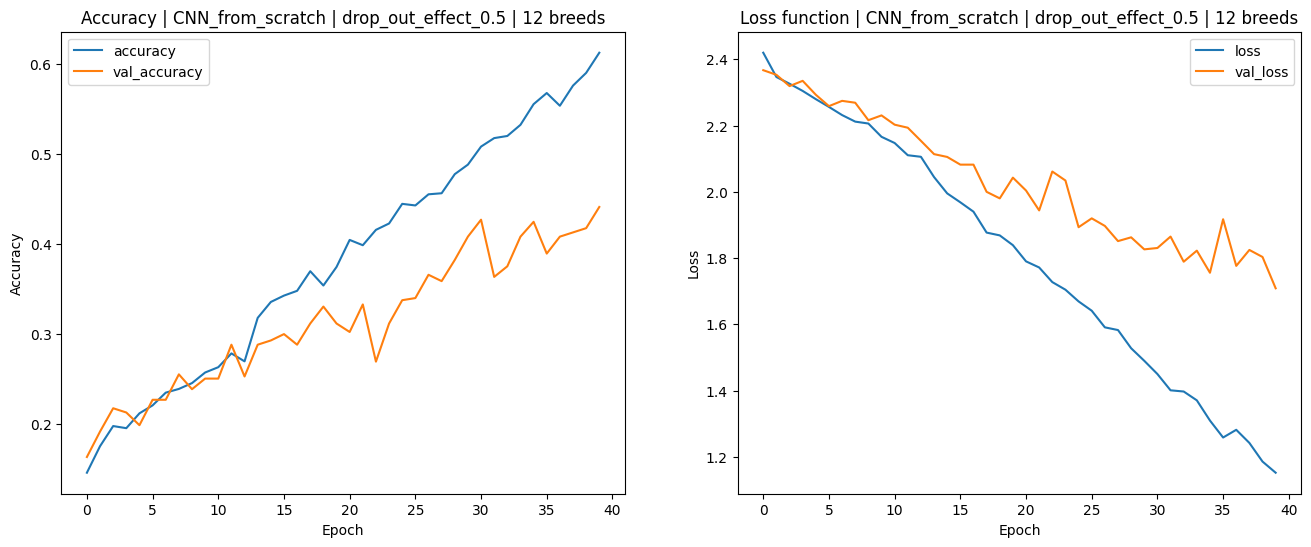

In [12]:
# Je teste 2 valeurs de dropout
value_lst = [0.2, 0.5]

for value in value_lst:
    print(f"Test de la valeur {value} en cours ...")
    
    model_dropout = get_model(act_function=act)
    model_dropout.add(Dropout(value))

    ### Couches de Classification
    # Applatissement (transform to vector 1D)
    model_dropout.add(GlobalAveragePooling2D())
    model_dropout.add(Dense(len(train_gen.class_indices), activation='softmax'))
    
    # Compilation
    model_dropout.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

    # Mesure des effets de la couche
    history_dropout = model_dropout.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

    title = "drop_out_effect_" + str(value)
    test_accuracy[title] = model_dropout.evaluate(test_gen)[1]
    plot_result_fitting(history_dropout, subtitle, title, n_breeds)

## 4.6  Mesure de l'effet de la data augmentation

53/53 [==============================] - 3s 53ms/step - loss: 1.8545 - accuracy: 0.3925


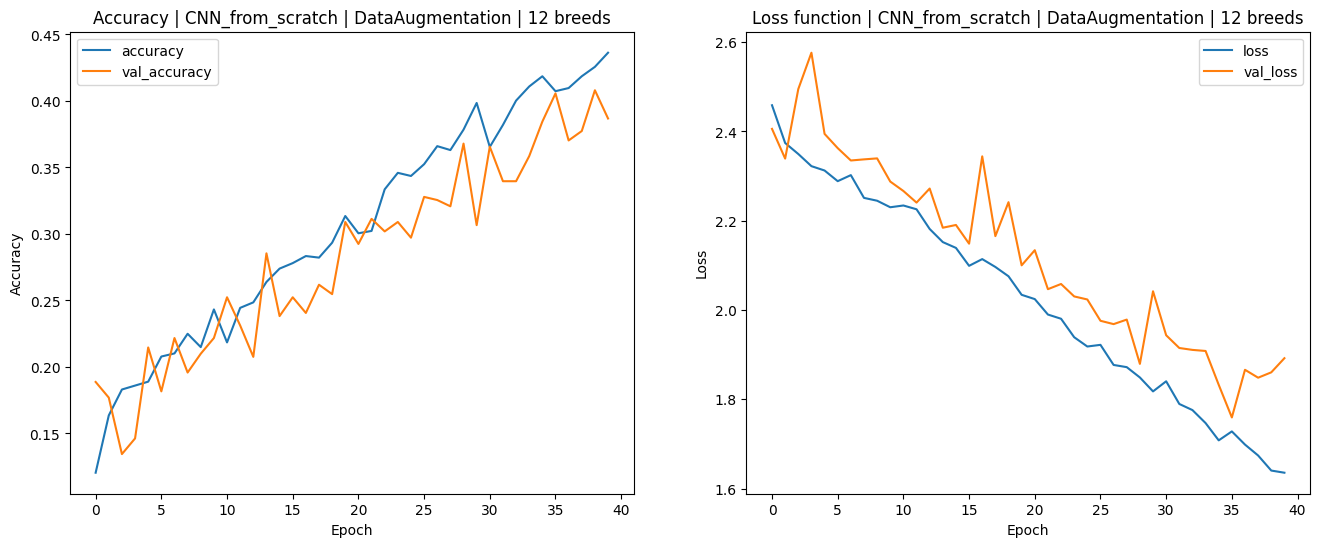

In [13]:
model_aug = get_model(act_function=act)

### Couches de Classification
# Applatissement (transform to vector 1D)
model_aug.add(GlobalAveragePooling2D())
model_aug.add(Dense(len(train_gen.class_indices), activation='softmax'))

model_aug.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
history_aug = model_aug.fit(train_gen_data_aug, validation_data=val_gen, epochs=epochs, verbose=verbose)

title = "DataAugmentation"
test_accuracy[title] = model_aug.evaluate(test_gen)[1]
plot_result_fitting(history_aug, subtitle, title, n_breeds)

## 4.7 Evaluation des tests

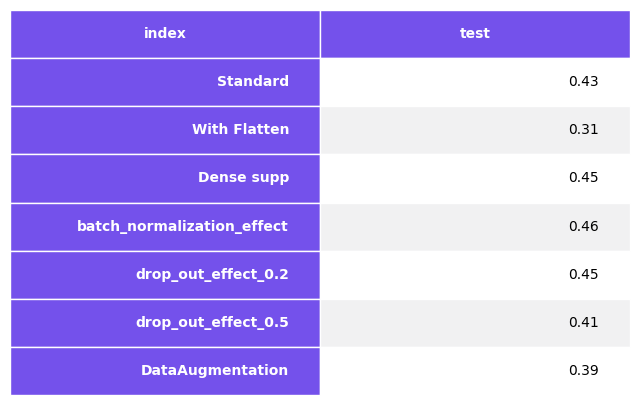

In [14]:
results = pd.DataFrame.from_dict(test_accuracy, orient='index').reset_index().rename(columns={0 : 'test'})
export_png_table(round(results, 2), col_width=4, filename='./cnn_from_scratch_results_' + str(n_breeds) + '_breeds.png')

---
# 5. Entrainement complet sur 12 races | Modèle optimisé

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 28, 28, 128)     

None

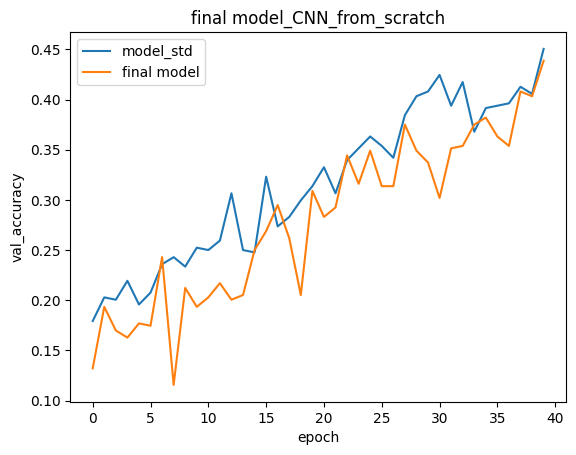

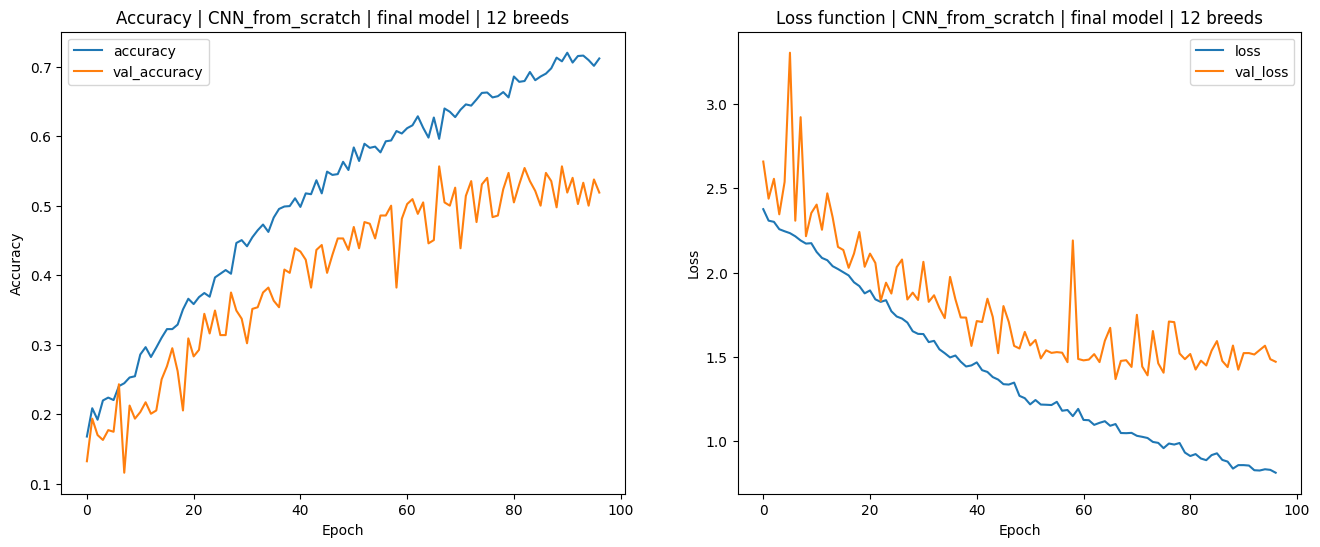

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [15]:
model_final = get_model(act_function=act)
model_final.add(Dropout(0.5))
model_final.add(BatchNormalization())

### Couches de Classification
model_final.add(GlobalAveragePooling2D())
model_final.add(Dense(256, activation=act))
model_final.add(Dense(len(train_gen.class_indices), activation='softmax'))

display(model_final.summary())

# Compliation
model_final.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=30)
history_final = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, verbose=verbose, callbacks=[early_stopping_monitor])

title = "final model"
plot_effect(history_std, history_final, title, subtitle)
plot_result_fitting(history_final, subtitle, title, n_breeds)
plot_confusion_matrix(model_final, title, n_breeds)

In [21]:
def plot_confusion_matrix(model, title, n_breeds):
    pred = model.predict(test_gen) 
    cf_matrix = confusion_matrix(test_gen.classes, pred)
    sns.heatmap(cf_matrix, cmap='Purples')
    plt.title('Matrice de confusion | ' + title + ' | ' + str(n_breeds) + ' breeds')
    plt.axis('off')
    plt.savefig('./cnn_transfer_learning_' + title + '_' + str(n_breeds) + '_breeds_confusion_matrix.png',
                transparent=True)
    plt.show()
    return

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 28, 28, 128)     

None

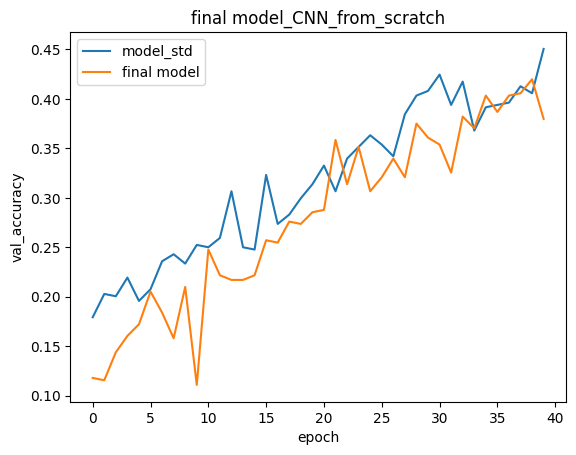

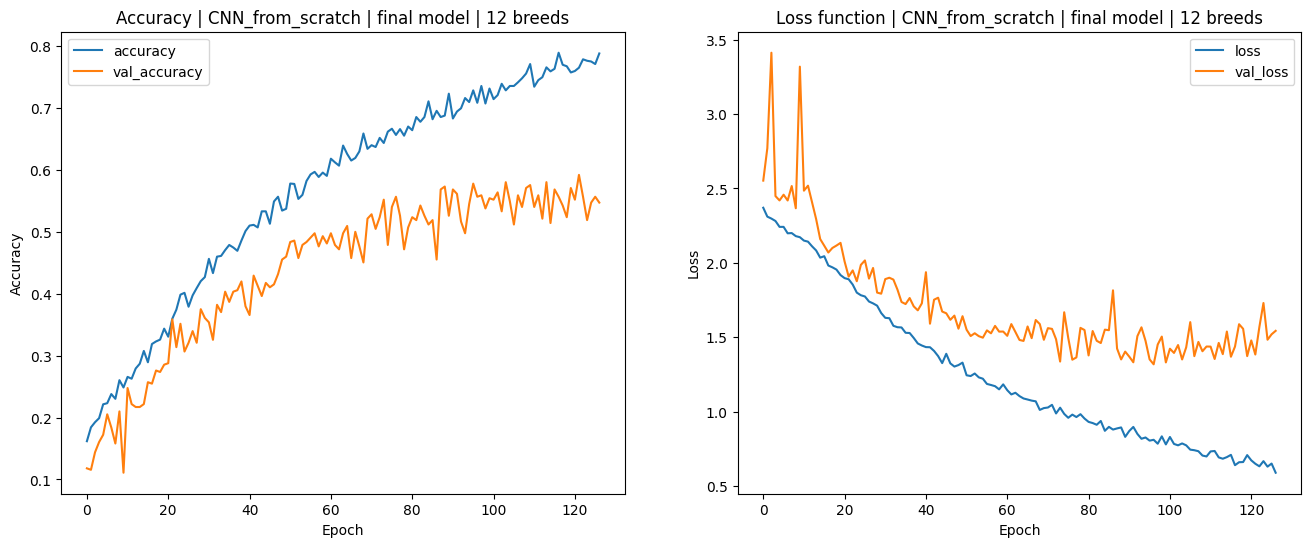

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [23]:
model_final = get_model(act_function=act)
model_final.add(Dropout(0.5))
model_final.add(BatchNormalization())

### Couches de Classification
model_final.add(GlobalAveragePooling2D())
model_final.add(Dense(256, activation=act))
model_final.add(Dense(len(train_gen.class_indices), activation='softmax'))

display(model_final.summary())

# Compliation
model_final.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=30)
history_final = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, verbose=verbose, callbacks=[early_stopping_monitor])

title = "final model"
plot_effect(history_std, history_final, title, subtitle)
plot_result_fitting(history_final, subtitle, title, n_breeds)
plot_confusion_matrix(model_final, title, n_breeds)

In [24]:
model_final.evaluate(test_gen)

53/53 [==============================] - 3s 59ms/step - loss: 1.6527 - accuracy: 0.5547


[1.6527200937271118, 0.5547170042991638]